# Sentiment Analysis Notebook 

In [3]:
# Utilities
from joblib import Parallel, delayed
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from multiprocessing import Pool, cpu_count
import warnings 
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import tqdm
from tqdm import tqdm
tqdm.pandas(desc="progress bar")
import gc
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

# Import time packages 
import time
import datetime

# Visualization Tools
import matplotlib.pyplot as plt

# Packages needed for text pre-processing:
import nltk 
import spacy 
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import Doc
from spacy.language import Language
import re
import contractions
import emoji
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Deep Learning Models 
import torch
import tensorflow as tf

# Sentiment Packages
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import torch
from scipy.special import softmax

import seaborn as sns 
import matplotlib.pyplot as plt 
# Applying Settings to Viaualization Tools 
plt.rcParams['font.size'] = 13
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
# Set color palette to blue shades
sns.set_palette(["#003366", "#6699CC", "#99CCFF", "#99CCFF"])
sns.set_palette(["#002855", "#3E7EAA", "#82B5D8", "#B3D9F2"])
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_style("darkgrid")


INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [4]:
from utils import search_folder
current_dir = os.getcwd()
thesis_folder_path = current_dir.replace("thesis_code", "")
twitter_data_path = search_folder(thesis_folder_path,"twitter_data")
eikon_data_path = search_folder(thesis_folder_path,"eikon_news")
stock_data_path = search_folder(thesis_folder_path,"stock_prices")
modelling_data_path = search_folder(thesis_folder_path,"modelling_data")
google_trending_path = search_folder(thesis_folder_path,"google_search")
gc.collect()

140

---
### Vader Sentiment Analyzer

VADER (Valence Aware Dictionary and Sentiment Reasoner) is a rule-based sentiment analysis tool that is specifically designed for analyzing sentiment in social media texts. It returns four values:

- Positive score: A float value between 0.0 and 1.0 indicating the proportion of the text that is positive.
- Negative score: A float value between 0.0 and 1.0 indicating the proportion of the text that is negative.
- Neutral score: A float value between 0.0 and 1.0 indicating the proportion of the text that is neutral.
- Compound score: A float value between -1.0 and 1.0 indicating the overall sentiment of the text, where values closer to -1.0 indicate a very negative sentiment and values closer to 1.0 indicate a very positive sentiment. A compound score of 0.0 indicates a neutral sentiment.


The compound score is calculated by combining the positive, negative, and neutral scores in a way that reflects the intensity and polarity of the sentiment expressed in the text. The compound score is the most useful metric for assessing the overall sentiment of a text.

Therefore, the expected output range for the positive, negative, and neutral scores from VADER Sentiment Analyzer is 0.0 to 1.0, and the expected output range for the compound score is -1.0 to 1.0.

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader_analyzer = SentimentIntensityAnalyzer()
def VaderSenti(text: str):
    vader_scores = vader_analyzer.polarity_scores(text)
    vader_results = list(vader_scores.values())
    result_series =  pd.Series({'Vader_neg': vader_results[0], 'Vader_neut': vader_results[1], 'Vader_pos': vader_results[2], 'Vader_sentim': vader_results[3]})
    return result_series

In [6]:
pos_text = "Apple latest revenue reports have increased share price"
neg_text = "Apple latest revenue reports have decreased share price"

In [7]:
VaderSenti("The bank earned 30% more money")

Vader_neg       0.0
Vader_neut      1.0
Vader_pos       0.0
Vader_sentim    0.0
dtype: float64

---
## FinBert Modelling

FinBERT is a pre-trained NLP model to analyze sentiment of financial text. It is built by further training the BERT language model in the finance domain, using a large financial corpus and thereby fine-tuning it for financial sentiment classification. Financial PhraseBank by Malo et al. (2014) is used for fine-tuning.

Negative score: A float value between 0.0 and 1.0 indicating the probability of the text expressing negative sentiment.

Positive score: A float value between 0.0 and 1.0 indicating the probability of the text expressing positive sentiment.
The sum of the negative and positive scores is always equal to 1.0.

Therefore, the expected output range for the negative and positive scores from the FinBERT model is 0.0 to 1.0, where larger values indicate a higher probability of the input text expressing negative or positive sentiment, respectively. The scores are probabilities, so their magnitudes are always between 0.0 and 1.0.

In [8]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
def FinBertSenti(text: str): 
    with tf.device('/device:GPU:0'):
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        probs = softmax(scores)
        pos_prob, neg_prob, neu_prob = probs
        sentiment_label = [1, -1, 0][probs.argmax()]
        result_series =  pd.Series({'Finbert_sentim_label': sentiment_label, 'Finbert_pos_prob': pos_prob, 'Finbert_neg_prob': neg_prob,'Finbert_neut_prob': neu_prob})
        return result_series

In [9]:
text = "Stocks rallied and the British pound gained."

In [10]:
FinBertSenti(text)

Finbert_sentim_label    1.000000
Finbert_pos_prob        0.898361
Finbert_neg_prob        0.034474
Finbert_neut_prob       0.067165
dtype: float64

---
## TextBlob

- Polarity is a float value within the range of -1.0 to 1.0, where -1.0 indicates a very negative sentiment and 1.0 indicates a very positive sentiment. A polarity value of 0.0 indicates a neutral sentiment.

- Subjectivity is a float value within the range of 0.0 to 1.0, where 0.0 indicates a very objective text and 1.0 indicates a very subjective text.

- Therefore, the expected output range for polarity is -1.0 to 1.0, and the expected output range for subjectivity is 0.0 to 1.0.

In [11]:
from textblob import TextBlob
def TextBlobSenti(text: str):
    TextBlobSenti = TextBlob(text).sentiment.polarity
    TextBlobObjecti = TextBlob(text).sentiment.subjectivity
    result_series =  pd.Series({'TextBlob_sentim': TextBlobSenti, 'TextBlob_objecti': TextBlobObjecti})
    return result_series

In [12]:
TextBlobSenti("I love pizza and i love you")

TextBlob_sentim     0.5
TextBlob_objecti    0.6
dtype: float64

---
## Compiled Sentiment Models

In [13]:
def sentiment_analyzer(df, sent_col: str):
    
    # 1. Performing FinBert Sentiment   
    with tf.device('/device:GPU:0'):
        df[["Finbert_sentim", "Finbert_pos", "Finbert_neg", "Finbert_neut"]] = df[sent_col].parallel_apply(lambda text:FinBertSenti(str(text)))
                
    # 2. TextBlob Sentiment Subjectivity 
    df[["Textblob_senti", "Textblob_obj"]] = df[sent_col].parallel_apply(lambda text:TextBlobSenti(str(text)))
    
    # 3. Perform VADER sentiment analysis
    df[["Vader_neg", "Vader_neut", "Vader_pos", "Vader_sentim"]] = df[sent_col].parallel_apply(lambda text: VaderSenti(str(text)))
                                                            
    return df   

---
## Twitter Data - Sentiment Analysis 

In [14]:
cleaned_tweets_df = pd.read_csv(twitter_data_path+ "/cleaned_tweets_df.csv")
cleaned_tweets_df["datetime"] = pd.to_datetime(cleaned_tweets_df["datetime"])
cleaned_tweets_df.head()

,datetime,username,text,rendered_content,likeCount,reply_count,retweet_count,retweeted,view_count,company,cleaned_text
0,2017-01-01 00:04:53+00:00,MacHashNews,Review: Bragi's Headphone offers a solid alter...,Review: Bragi's Headphone offers a solid alter...,0.0,0.0,2.0,NaN,NaN,apple,review 's headphone offers a solid alternative...
1,2017-01-01 00:05:05+00:00,marketexclusive,Analyst Activity – Robert W. Baird Reiterates ...,Analyst Activity – Robert W. Baird Reiterates ...,0.0,0.0,7.0,NaN,NaN,tesla,analyst activity robert w. baird reiterates to...
2,2017-01-01 00:14:25+00:00,helpYOUgetGAINS,Roasted Persian Chicken and Cauliflower | Mark...,Roasted Persian Chicken and Cauliflower | Mark...,0.0,0.0,0.0,NaN,NaN,apple,roasted persian chicken and cauliflower | mark...
3,2017-01-01 00:38:06+00:00,jhamby,Apple also integrated DTrace into macOS and wr...,Apple also integrated DTrace into macOS and wr...,0.0,0.0,0.0,NaN,NaN,apple,apple also integrated into macos and wrote som...
4,2017-01-01 00:54:59+00:00,HuffPost,Google combats Holocaust-denying search result...,Google combats Holocaust-denying search result...,151.0,10.0,63.0,NaN,NaN,google,google combats holocaust denying search result...


In [15]:
#pandarallel.initialize(progress_bar=True)

In [16]:
# iter_save = 20000
# try: 
#     twitter_senti_df = pd.read_csv(twitter_data_path +"/twitter_senti_raw_df.csv")
#     with tf.device('/device:GPU:0'):
#         for i in tqdm(range(0, len(cleaned_tweets_df), iter_save)):
#             temp = cleaned_tweets_df.iloc[i:i+iter_save]
#             senti_temp = sentiment_analyzer(temp, "text")
#             twitter_senti_df = pd.concat([twitter_senti_df,senti_temp])
#             twitter_senti_df.to_csv(twitter_data_path + "/twitter_senti_raw_df.csv", index = False)
# except:
#     #print(e)
#     twitter_senti_df.to_csv(twitter_data_path + "/twitter_senti_raw_df.csv", index = False)
#     print("Stopped at iteration {}".format(i/iter_save))  #214.02s/it

In [17]:
twitter_senti_raw_df = pd.read_csv(twitter_data_path +"/twitter_senti_raw_df.csv")
twitter_senti_raw_df["datetime"] = pd.to_datetime(twitter_senti_raw_df["datetime"])
twitter_senti_raw_df =twitter_senti_raw_df.sort_values(by = "datetime")

In [18]:
twitter_senti_df = pd.read_csv(twitter_data_path +"/twitter_senti_df.csv")
twitter_senti_df["datetime"] = pd.to_datetime(twitter_senti_df["datetime"])
twitter_senti_df =twitter_senti_df.sort_values(by = "datetime")
twitter_senti_df = twitter_senti_df.drop_duplicates()

In [145]:
print(cleaned_tweets_df.shape)
print(twitter_senti_raw_df.shape)
print(twitter_senti_df.shape)

(2157988, 11)
(2157990, 21)
(2157988, 21)


In [146]:
twitter_senti_df.iloc[428774]

datetime                                    2018-05-31 15:56:56+00:00
username                                               MarketCurrents
text                Google and Orange team to fund tech startups i...
rendered_content    Google and Orange team to fund tech startups i...
likeCount                                                         0.0
reply_count                                                       0.0
retweet_count                                                     1.0
retweeted                                                         NaN
view_count                                                        NaN
company                                                        google
cleaned_text        google and orange team to fund tech startups i...
Finbert_sentim                                                    0.0
Finbert_pos                                                  0.125405
Finbert_neg                                                  0.008427
Finbert_neut        

In [24]:
#fixed_twitter_senti_raw_df = fix_data(twitter_senti_df, "datetime")
fixed_twitter_senti_raw_df = twitter_senti_df

---
# Preparing Sentiment Variable for Modelling

In [25]:
def update_sentiment(df): 
    
    #df = df.fillna({'likeCount': 0.0, 'reply_count':'0.0', "retweet_count": 0.0, "view_count": 0.0}).fillna(0)
    df = df.fillna(0.0)
    df["tweet_weight"] = 1
    df["date"] = df.datetime.dt.date
    daytweets = pd.DataFrame(df.groupby(by=["date"])["text"].count())
    daytweets = daytweets.rename(columns={"text": "daytweets"})
    df = pd.merge(df, daytweets, left_on=pd.to_datetime(df["datetime"]).dt.date, right_on="date")
    
    df["rolling_mean_likes"] = df["likeCount"].rolling(10000, min_periods=1).mean()
    df["rolling_std_likes"] = df["likeCount"].rolling(10000, min_periods=1).std()
    
    df["rolling_mean_replies"] = df["reply_count"].rolling(10000, min_periods=1).mean()
    df["rolling_std_replies"] = df["reply_count"].rolling(10000, min_periods=1).std()
    
    df["rolling_mean_retweets"] = df["retweet_count"].rolling(10000, min_periods=1).mean()
    df["rolling_std_retweets"] = df["retweet_count"].rolling(10000, min_periods=1).std()
    
    df.loc[(df["likeCount"] >= df["rolling_mean_likes"]) &  (df["likeCount"] < (df["rolling_mean_likes"] + df["rolling_std_likes"])), "tweet_weight"] += 1
    df.loc[(df["likeCount"] >= (df["rolling_mean_likes"]+ df["rolling_std_likes"])) &  (df["likeCount"] < (df["rolling_mean_likes"] + df["rolling_std_likes"]*2)), "tweet_weight"] += 2
    df.loc[(df["likeCount"] >= (df["rolling_mean_likes"]+ df["rolling_std_likes"]*2)), "tweet_weight"] +=3
    
    df.loc[(df["reply_count"] >= df["rolling_mean_replies"]) &  (df["reply_count"] < (df["rolling_mean_replies"] + df["rolling_std_replies"])), "tweet_weight"] += 1
    df.loc[(df["reply_count"] >= (df["rolling_mean_replies"]+ df["rolling_std_replies"])) &  (df["reply_count"] < (df["rolling_std_replies"] + df["rolling_std_replies"]*2)), "tweet_weight"] += 2
    df.loc[(df["reply_count"] >= (df["rolling_mean_replies"]+ df["rolling_std_replies"]*2)), "tweet_weight"] +=3
    
    df.loc[(df["retweet_count"] >= df["rolling_mean_retweets"]) &  (df["retweet_count"] < (df["rolling_mean_retweets"] + df["rolling_std_retweets"])), "tweet_weight"] += 1
    df.loc[(df["retweet_count"] >= (df["rolling_mean_retweets"]+ df["rolling_std_retweets"])) &  (df["retweet_count"] < (df["rolling_mean_retweets"] + df["rolling_std_retweets"]*2)), "tweet_weight"] += 2
    df.loc[(df["retweet_count"] >= (df["rolling_mean_retweets"]+ df["rolling_std_retweets"]*2)), "tweet_weight"] +=3
    
    # Applying the tweet weight 
    df["Textblob_senti_weighted"] = df["Textblob_senti"] *  df["tweet_weight"]
    df["Vader_sentim_weighted"] = df["Vader_sentim"] *  df["tweet_weight"]
    df["Finbert_sentim_weighted"] = df["Finbert_sentim"] *  df["tweet_weight"]
    
    df = df[["datetime","date","company", "Textblob_senti_weighted", "Textblob_senti", "Vader_sentim_weighted" , "Vader_sentim", "Finbert_sentim_weighted", "Finbert_sentim",
             "tweet_weight",'likeCount', 'reply_count', 'retweet_count','view_count', "daytweets", "rolling_mean_likes", "rolling_std_likes"]]
    
    df = df.set_index(pd.to_datetime(df.datetime), drop= True)
    df = df.drop(columns="datetime")
    df = df.fillna(0.0)
    df2 = df.groupby(by = "date").sum()
    df2["company"] = df["company"].iloc[0]
    
    textblob_hsm = df2["Textblob_senti_weighted"].mean()
    textblob_hsstd = df2["Textblob_senti_weighted"].std()
    
    Vader_hsm = df2["Vader_sentim_weighted"].mean()
    Vader_hsstd = df2["Vader_sentim_weighted"].std()
    
    Finbert_hsm = df2["Textblob_senti_weighted"].mean()
    Finbert_hsstd = df2["Textblob_senti_weighted"].std()
    
    #Z-Score = (Daily or Weekly Average Sentiment Score - Mean Historical Sentiment Score) / Standard Deviation of Historical Sentiment Scores
    df2["TextBlob_z_score"] = df2["Textblob_senti_weighted"].apply(lambda x: ((x - textblob_hsm) / textblob_hsstd))
    df2["Vader_z_score"] = df2["Vader_sentim_weighted"].apply(lambda x: ((x - Vader_hsm) / Vader_hsstd))
    df2["Finbert_z_score"] = df2["Textblob_senti_weighted"].apply(lambda x: ((x - Finbert_hsm) / Finbert_hsstd))
    
    return df2

In [26]:
senti_df = pd.DataFrame()
for comp in ["google", "tesla", "moderna", "apple"]:
    company = fixed_twitter_senti_raw_df[fixed_twitter_senti_raw_df["company"] == comp]
    temp = update_sentiment(company)
    senti_df = pd.concat([senti_df, temp])

In [29]:
test = senti_df[senti_df["company"] == "moderna"]
test.head()

,company,Textblob_senti_weighted,Textblob_senti,Vader_sentim_weighted,Vader_sentim,Finbert_sentim_weighted,Finbert_sentim,tweet_weight,likeCount,reply_count,retweet_count,view_count,daytweets,rolling_mean_likes,rolling_std_likes,TextBlob_z_score,Vader_z_score,Finbert_z_score
date,,,,,,,,,,,,,,,,,,
2017-01-03,moderna,0.000000,0.000000,2.3976,0.5994,4.0,1.0,5,2.0,0.0,4.0,0.0,4,3.000000,1.414214,-0.385412,-0.190438,-0.385412
2017-01-04,moderna,8.656061,1.309848,16.0003,3.0466,0.0,0.0,29,10.0,0.0,10.0,0.0,36,9.164286,13.932966,0.330963,0.469282,0.330963
2017-01-05,moderna,2.200000,0.550000,1.6860,0.4215,0.0,0.0,4,1.0,0.0,0.0,0.0,1,1.444444,2.554952,-0.203340,-0.224950,-0.203340
2017-01-08,moderna,-0.018182,-0.004545,2.1068,0.5267,4.0,1.0,4,0.0,0.0,0.0,0.0,1,1.300000,2.451757,-0.386917,-0.204541,-0.386917
2017-01-09,moderna,8.171212,1.215530,15.2425,2.3788,25.0,3.0,50,36.0,0.0,23.0,0.0,64,15.829129,25.813881,0.290837,0.432529,0.290837


In [153]:
current_date = pd.to_datetime("2017-01-02")
current_date.weekday()

0

In [154]:
senti_df.to_csv(modelling_data_path + "/senti_cleaned_df.csv")

<Axes: xlabel='date'>

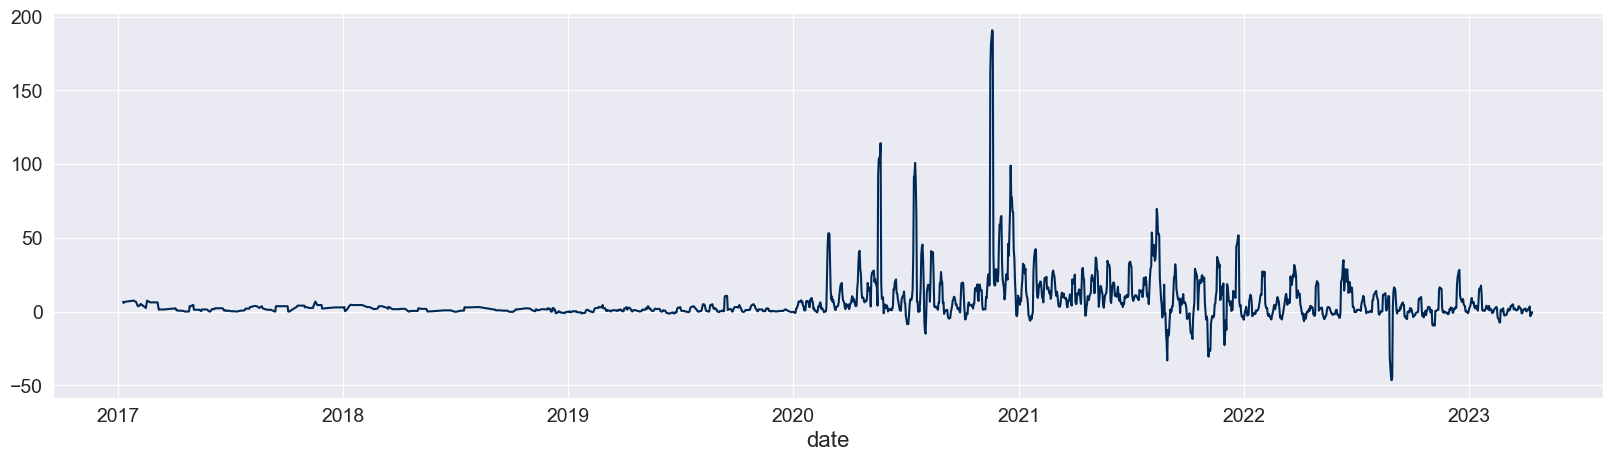

In [30]:
test["rolling_z_score"] = test.Finbert_sentim_weighted.rolling(5).mean()
test["rolling_z_score"].plot(figsize=(20,5))

<Axes: xlabel='date'>

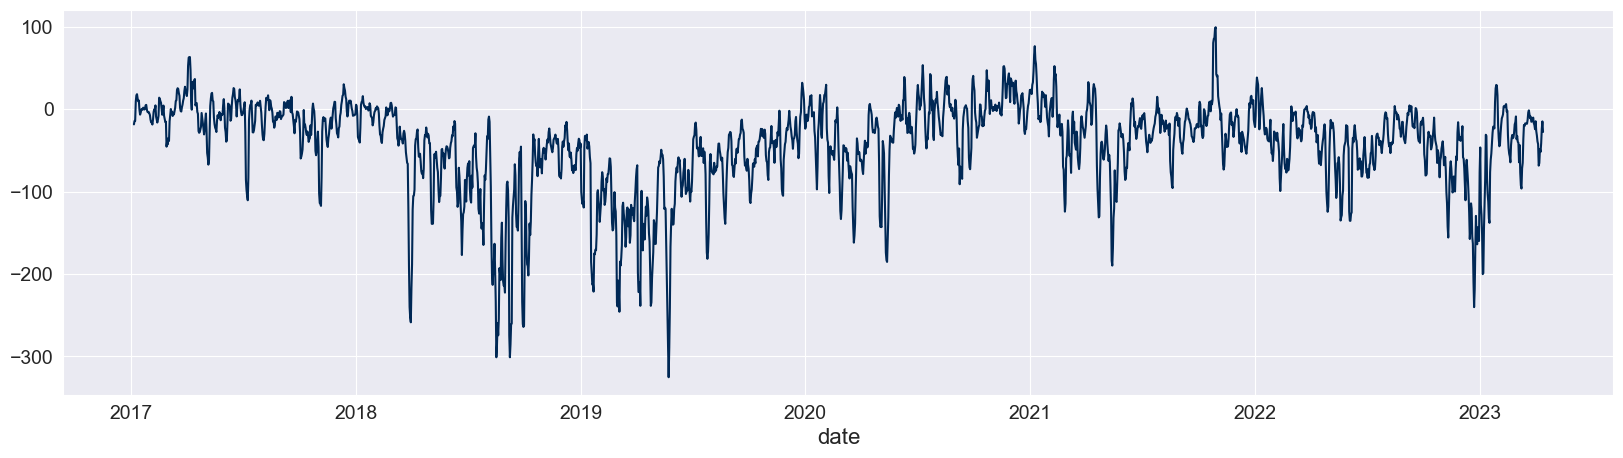

In [91]:
test["rolling_z_score"] = test.Finbert_sentim_weighted.rolling(5).mean()
test["rolling_z_score"].plot(figsize=(20,5))

<Axes: xlabel='date'>

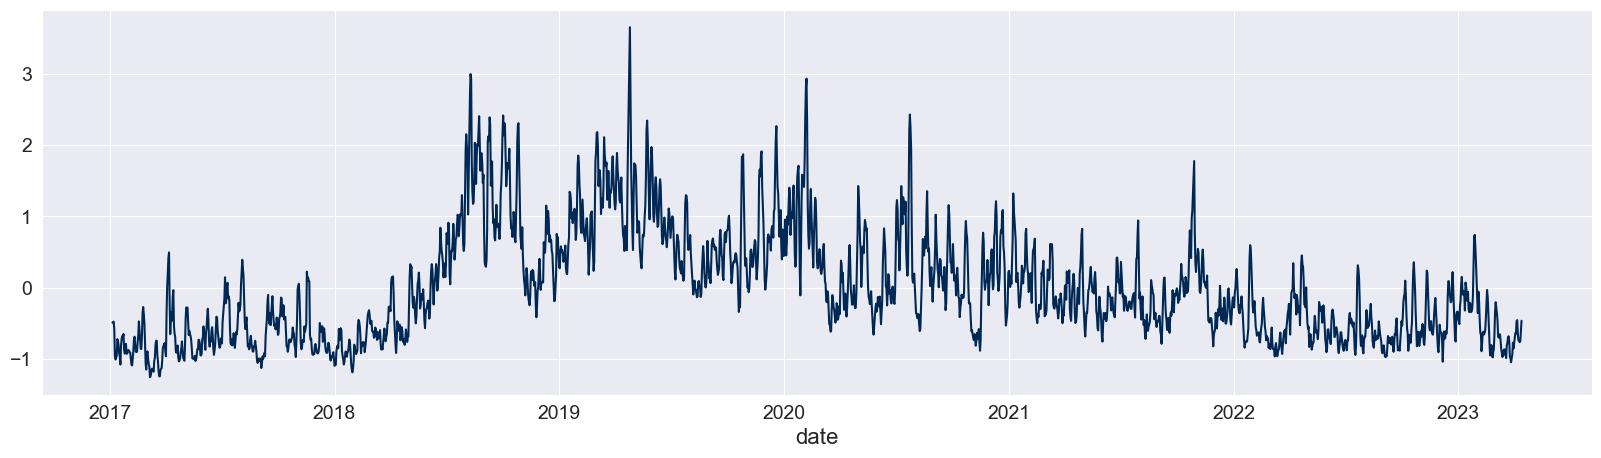

In [105]:
test["rolling_z_score"] = test.Finbert_z_score.rolling(5).mean()
test["rolling_z_score"].plot(figsize=(20,5))

<Axes: xlabel='date'>

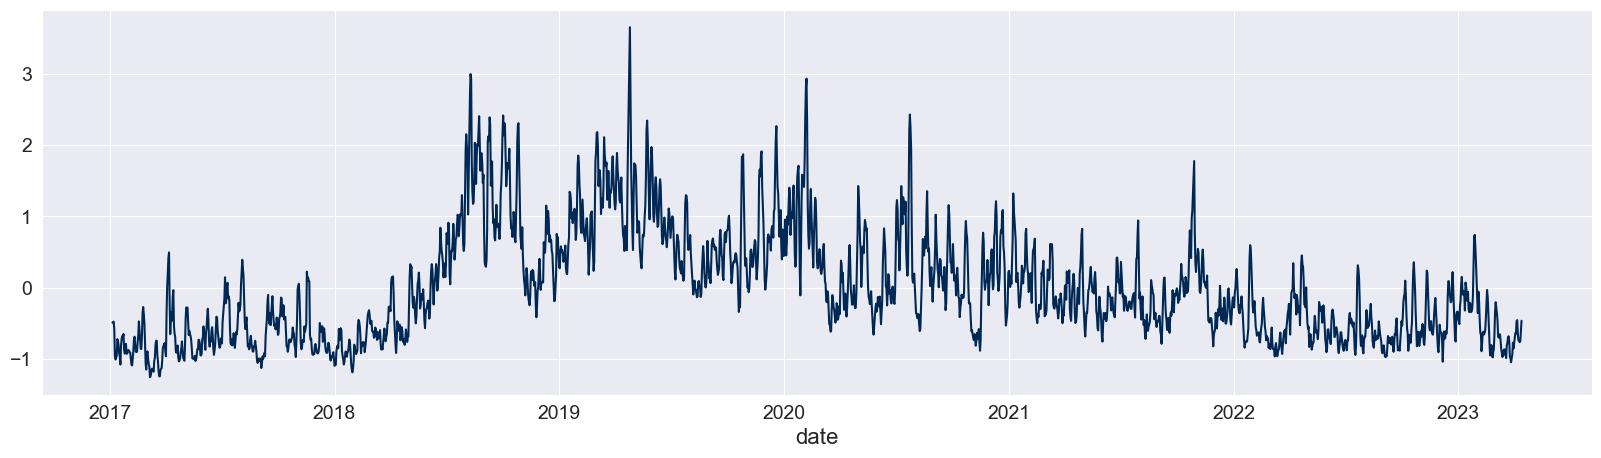

In [92]:
df2["rolling_z_score"] = df2.Finbert_z_score.rolling(5).mean()
df2["rolling_z_score"].plot(figsize=(20,5))

<Axes: xlabel='date'>

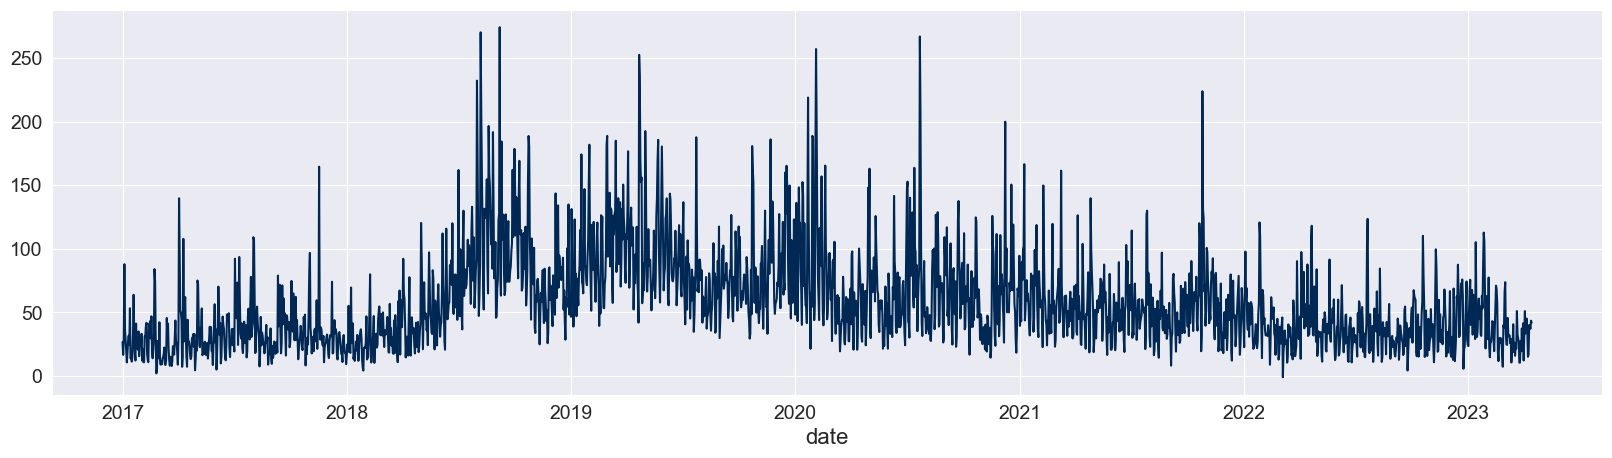

In [57]:
df2.Textblob_senti_weighted.plot(figsize=(20,5))

In [60]:
df2["rollingS"] = df2["Textblob_senti_weighted"].rolling(21).sum()
df2["rollingSW"] = df2["Textblob_senti_weighted"].rolling(5).sum()

<Axes: xlabel='date'>

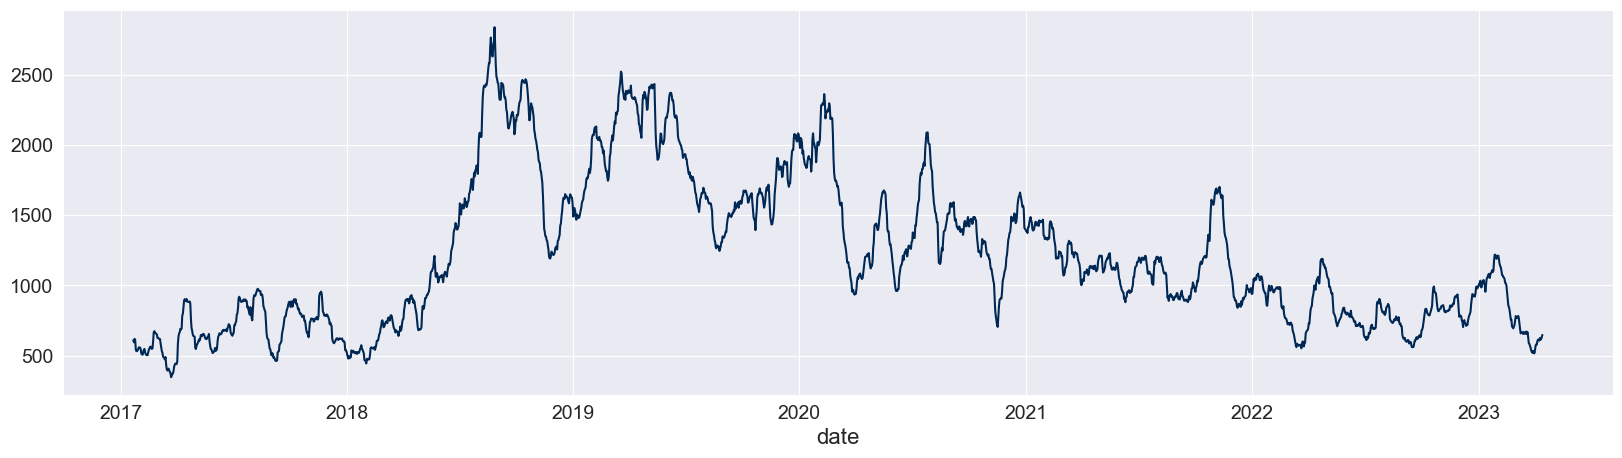

In [61]:
df2.rollingS.plot(figsize=(20,5))

<Axes: xlabel='date'>

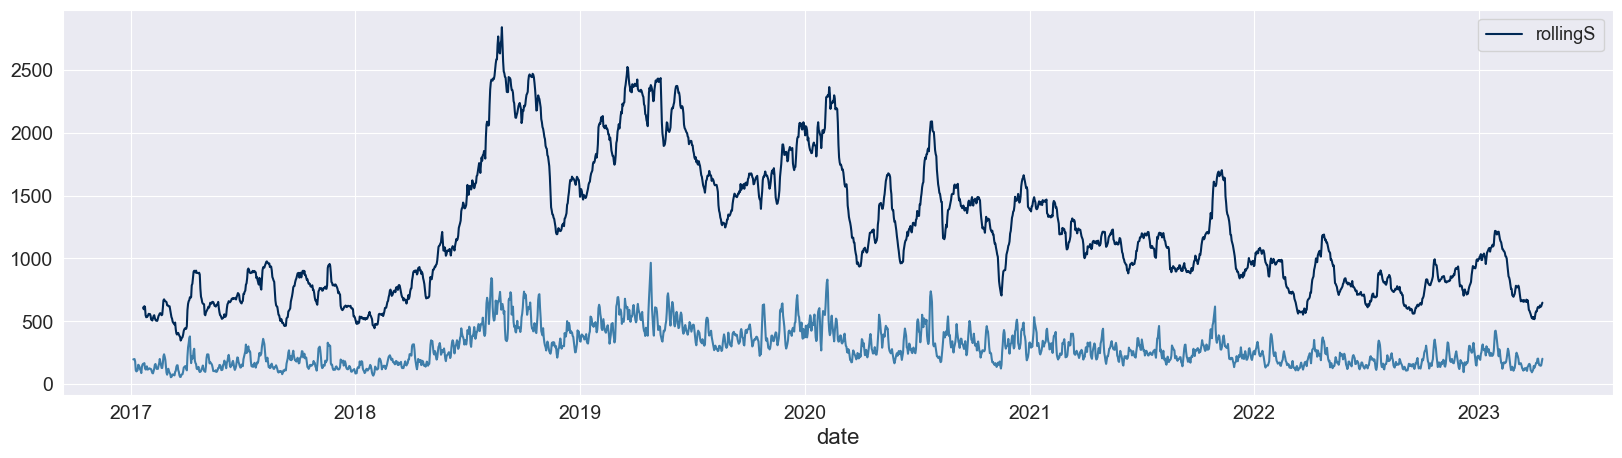

In [62]:
df2.rollingS.plot(figsize=(20,5), legend="100days")
df2.rollingSW.plot(figsize=(20,5)) # sentiment may not predict day ahead price or returns but maybe weeks ahead.

In [141]:
def fix_data(df, date_column): 
    for idx in tqdm(range(len(df))):
        
        current_date = pd.to_datetime(df[date_column].iloc[idx], errors='coerce')
        
        if current_date.weekday() == 6:
            df.at[idx, date_column] = current_date + pd.Timedelta(days=2)
        
        elif current_date.weekday() == 7: 
            
            df.at[idx, date_column] = current_date + pd.Timedelta(days=1) 
        else:
            continue
    
    return df

In [41]:
twitter_senti_df

,datetime,username,text,rendered_content,likeCount,reply_count,retweet_count,retweeted,view_count,company,...,Finbert_sentim,Finbert_pos,Finbert_neg,Finbert_neut,Textblob_senti,Textblob_obj,Vader_neg,Vader_neut,Vader_pos,Vader_sentim
0,2017-01-01 00:04:53+00:00,MacHashNews,Review: Bragi's Headphone offers a solid alter...,Review: Bragi's Headphone offers a solid alter...,0.0,0.0,2.0,NaN,NaN,apple,...,1.0,0.770312,0.008197,0.221491,0.050000,0.050000,0.000,0.873,0.127,0.1531
1,2017-01-01 00:05:05+00:00,marketexclusive,Analyst Activity – Robert W. Baird Reiterates ...,Analyst Activity – Robert W. Baird Reiterates ...,0.0,0.0,7.0,NaN,NaN,tesla,...,0.0,0.116314,0.033758,0.849928,0.500000,0.500000,0.000,0.878,0.122,0.2023
2,2017-01-01 00:14:25+00:00,helpYOUgetGAINS,Roasted Persian Chicken and Cauliflower | Mark...,Roasted Persian Chicken and Cauliflower | Mark...,0.0,0.0,0.0,NaN,NaN,apple,...,0.0,0.045890,0.020444,0.933666,-0.300000,0.475000,0.000,1.000,0.000,0.0000
3,2017-01-01 00:38:06+00:00,jhamby,Apple also integrated DTrace into macOS and wr...,Apple also integrated DTrace into macOS and wr...,0.0,0.0,0.0,NaN,NaN,apple,...,0.0,0.074651,0.014470,0.910879,0.600000,1.000000,0.000,0.781,0.219,0.4215
4,2017-01-01 00:54:59+00:00,HuffPost,Google combats Holocaust-denying search result...,Google combats Holocaust-denying search result...,151.0,10.0,63.0,NaN,NaN,google,...,0.0,0.060525,0.272742,0.666733,0.000000,0.000000,0.375,0.625,0.000,-0.4939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2167983,2023-04-14 23:35:57+00:00,TopStockAlerts1,$TSLA Tesla Stock Drops on More Price Cuts. In...,$TSLA Tesla Stock Drops on More Price Cuts. In...,0.0,1.0,0.0,NaN,2208.0,tesla,...,-1.0,0.041936,0.704869,0.253195,0.500000,0.500000,0.184,0.816,0.000,-0.3566
2167984,2023-04-14 23:43:42+00:00,smtraderCA,Will be watching $NFLX &amp; $TSLA,Will be watching $NFLX &amp; $TSLA,4.0,0.0,0.0,NaN,365.0,tesla,...,0.0,0.037660,0.023327,0.939013,0.000000,0.000000,0.000,1.000,0.000,0.0000
2167985,2023-04-14 23:51:48+00:00,sleekoptions,$TSLA - View historical options performance fo...,$TSLA - View historical options performance fo...,0.0,0.0,0.0,NaN,79.0,tesla,...,0.0,0.048452,0.018570,0.932978,0.000000,0.000000,0.000,1.000,0.000,0.0000
2167986,2023-04-14 23:57:05+00:00,racernic,Recap of today's action and the overall plan f...,Recap of today's action and the overall plan f...,5.0,1.0,0.0,NaN,416.0,tesla,...,0.0,0.054431,0.022855,0.922714,0.033333,0.033333,0.000,1.000,0.000,0.0000


In [ ]:
dd

In [43]:
senti_quick_test = twitter_senti_df[twitter_senti_df["company"]== "moderna"] 
senti_quick_test = senti_quick_test.set_index(pd.to_datetime(senti_quick_test.datetime))
senti_quick_test = senti_quick_test[["Textblob_senti", "Vader_sentim", "Finbert_sentim"]].resample("D").sum()

In [49]:
senti_quick_test.corr()

,Textblob_senti,Vader_sentim,Finbert_sentim
Textblob_senti,1.000000,0.887708,0.728006
Vader_sentim,0.887708,1.000000,0.817064
Finbert_sentim,0.728006,0.817064,1.000000


<Axes: xlabel='datetime'>

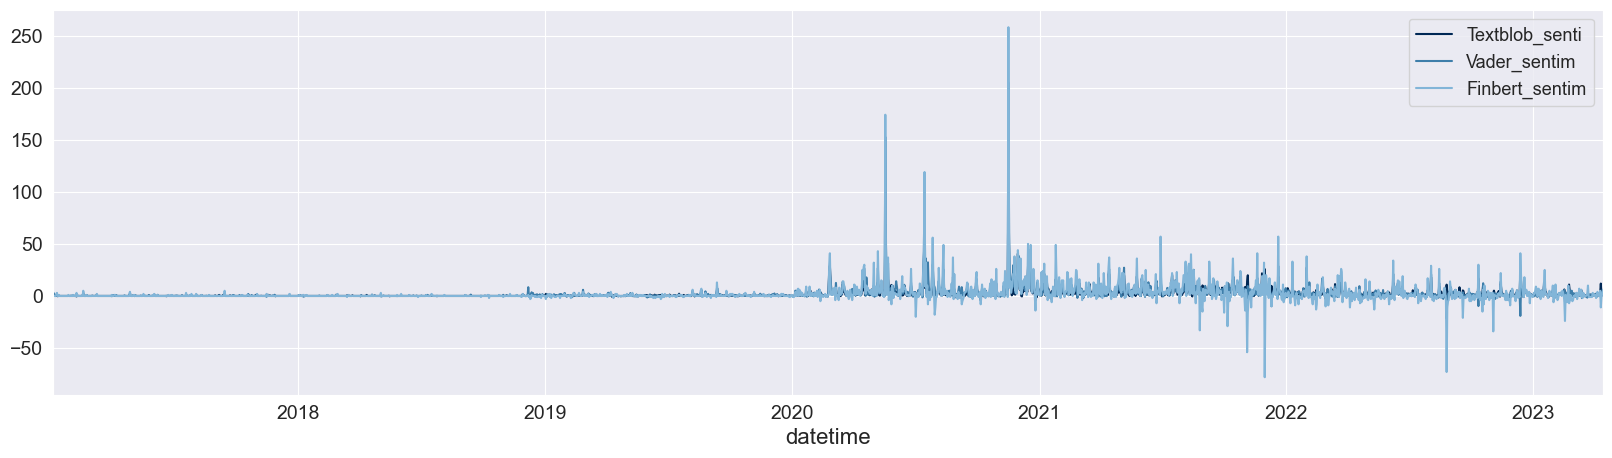

In [39]:
senti_quick_test[["Textblob_senti", "Vader_sentim", "Finbert_sentim"]].plot(figsize = (20,5))

In [19]:
senti_quick_test["rolled_Vader_sentim"] = senti_quick_test["Vader_sentim"].rolling(30).mean()

<Axes: xlabel='datetime'>

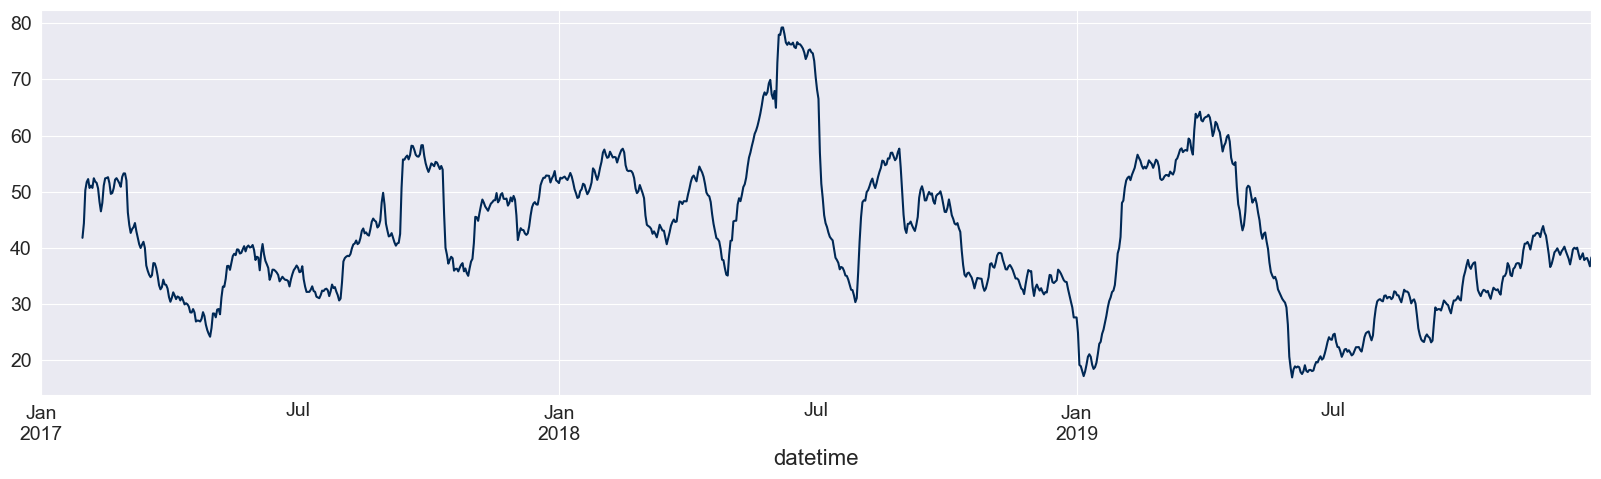

In [20]:
senti_quick_test["rolled_Vader_sentim"].plot(figsize = (20,5))

<Axes: xlabel='datetime'>

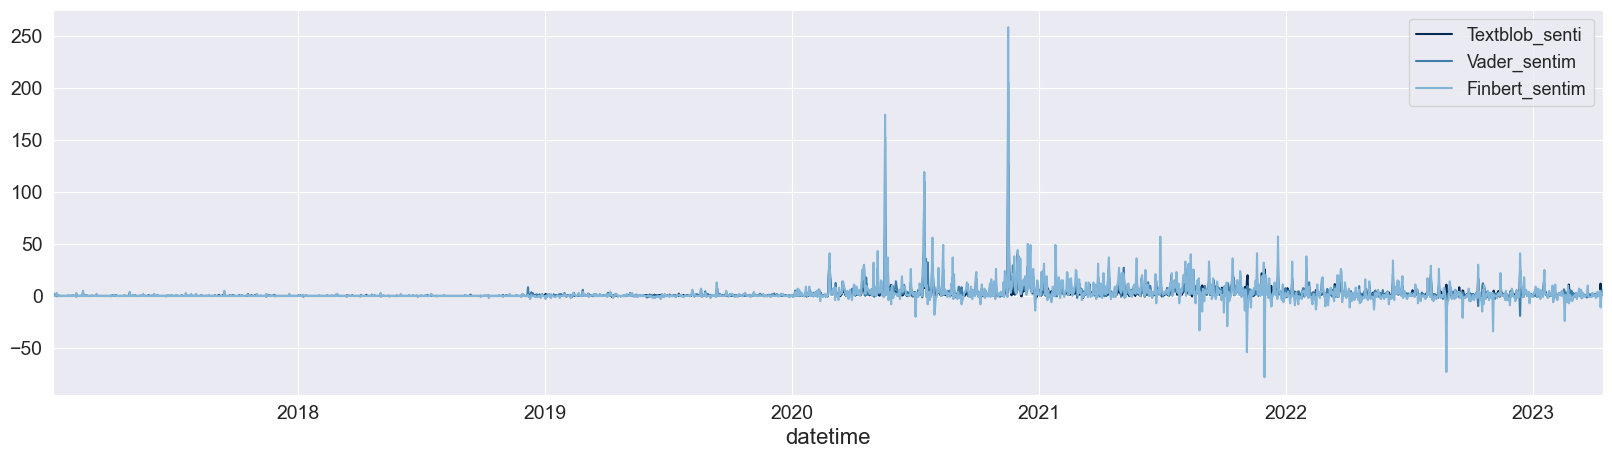

In [31]:
senti_quick_test[["Textblob_senti", "Vader_sentim", "Finbert_sentim"]].plot(figsize = (20,5))

---
## Reuters Data - Sentiment Analysis

In [20]:
eikon_news_df = pd.read_csv(eikon_data_path + "/cleaned_eikon_news_df.csv")
eikon_news_df["datetime"] = pd.to_datetime(eikon_news_df["datetime"])
#eikon_news_df = eikon_news_df.sort_values(by = "datetime", ascending = True).reset_index(drop = True)
eikon_news_df.head()

,datetime,source,stock,text,company,cleaned_text
0,2017-01-01 12:44:28,ZOLCOM,AAPL.OQ,Apple Inc. (AAPL) Sees Large Drop in Short Int...,apple,apple inc apple sees large drop in short interest
1,2017-01-01 16:34:58,ZOLCOM,AAPL.OQ,"JLB & Associates Inc. Has $10,751,000 Position...",apple,"associates inc has $ 10,751,000 position in ap..."
2,2017-01-02 09:24:17,RTRS,.GDAXI .IBEX,German and French share indexes start 2017 on ...,apple,german and french share indexes start 2017 on ...
3,2017-01-02 09:52:42,RTRS,AAPL.O DLGS.DE,BUZZ-Dialog Semi: Falls on report Apple plans ...,apple,buzz dialog semi falls on report apple plans i...
4,2017-01-02 22:54:59,AMEBAN,TSLA.OQ,"Tesla Motors, Inc. (TSLA) Downgraded by Vetr Inc.",tesla,tesla motors inc tesla downgraded by inc


In [ ]:
pandarallel.initialize(progress_bar=True)

In [ ]:
raw_eikon_senti_df = sentiment_analyzer(eikon_news_df, "text")

In [23]:
#senti_quick_test.to_csv(twitter_data_path + "/quick_test.csv")

---
# Moderna Quick Evaluation

In [82]:
moderna_quick_test = raw_eikon_senti_df[raw_eikon_senti_df["company"] == "moderna"]

In [83]:
senti_quick_test = moderna_quick_test.copy()
senti_quick_test = senti_quick_test.set_index(pd.to_datetime(senti_quick_test.datetime))
senti_quick_test = senti_quick_test[["Textblob_senti", "Vader_sentim", "Finbert_sentim"]].resample("D").sum()

In [84]:
senti_quick_test.corr()

,Textblob_senti,Vader_sentim,Finbert_sentim
Textblob_senti,1.000000,0.501344,0.357243
Vader_sentim,0.501344,1.000000,0.660293
Finbert_sentim,0.357243,0.660293,1.000000


<Axes: xlabel='datetime'>

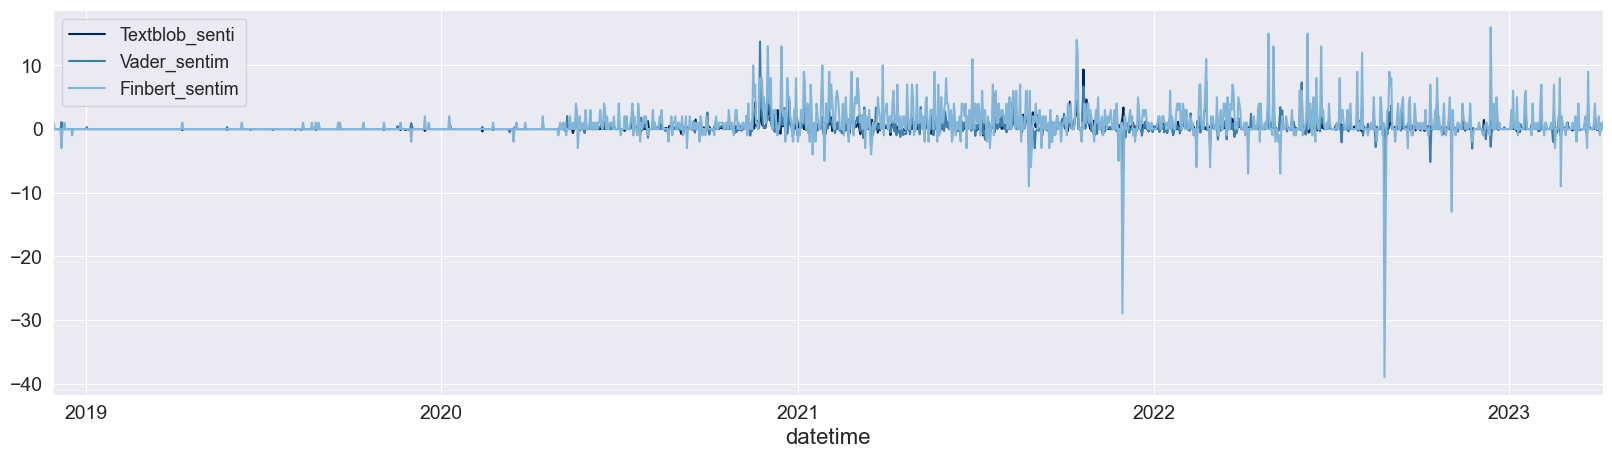

In [85]:
senti_quick_test[["Textblob_senti", "Vader_sentim", "Finbert_sentim"]].plot(figsize = (20,5))

<Axes: xlabel='datetime'>

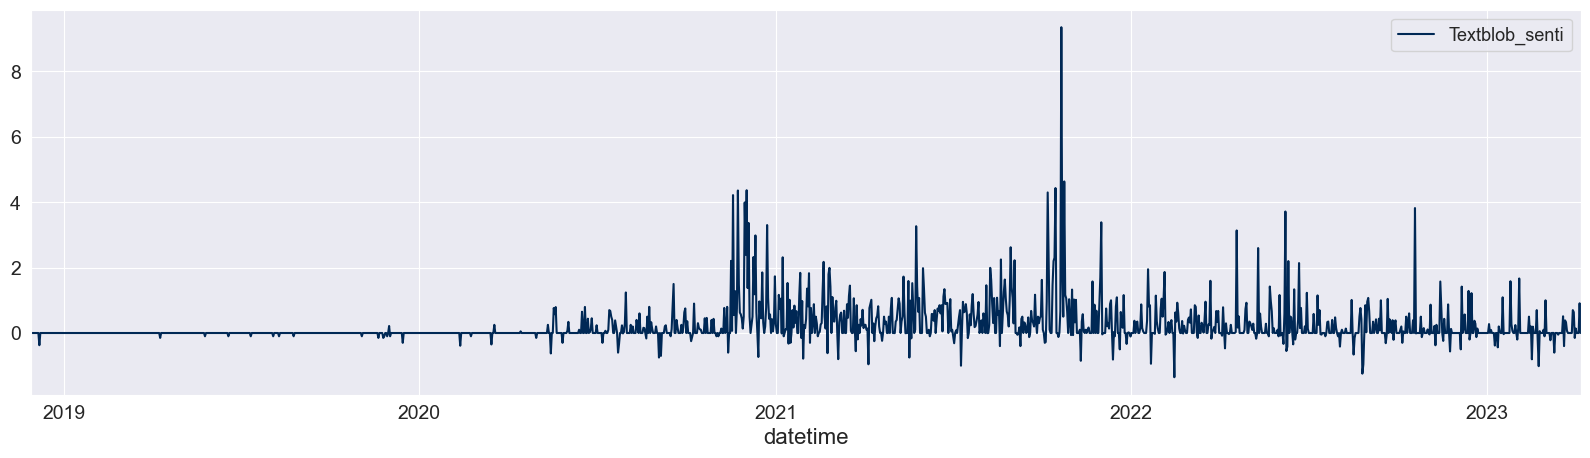

In [86]:
senti_quick_test[["Textblob_senti"]].plot(figsize = (20,5))

<Axes: xlabel='datetime'>

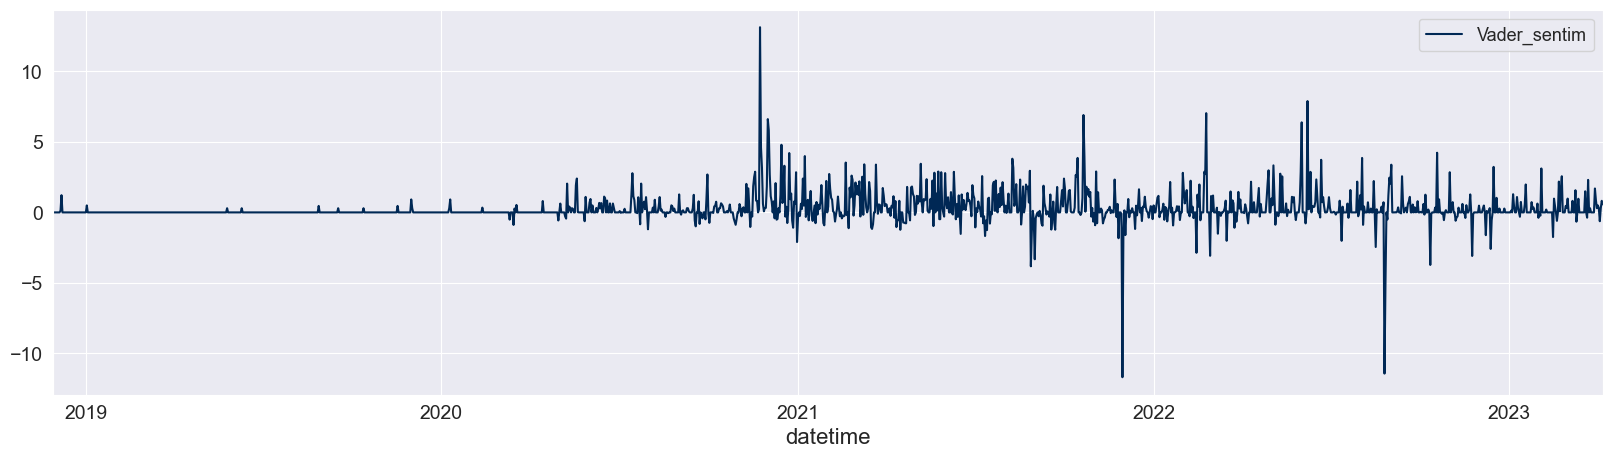

In [30]:
senti_quick_test[["Vader_sentim"]].plot(figsize = (20,5))

<Axes: xlabel='datetime'>

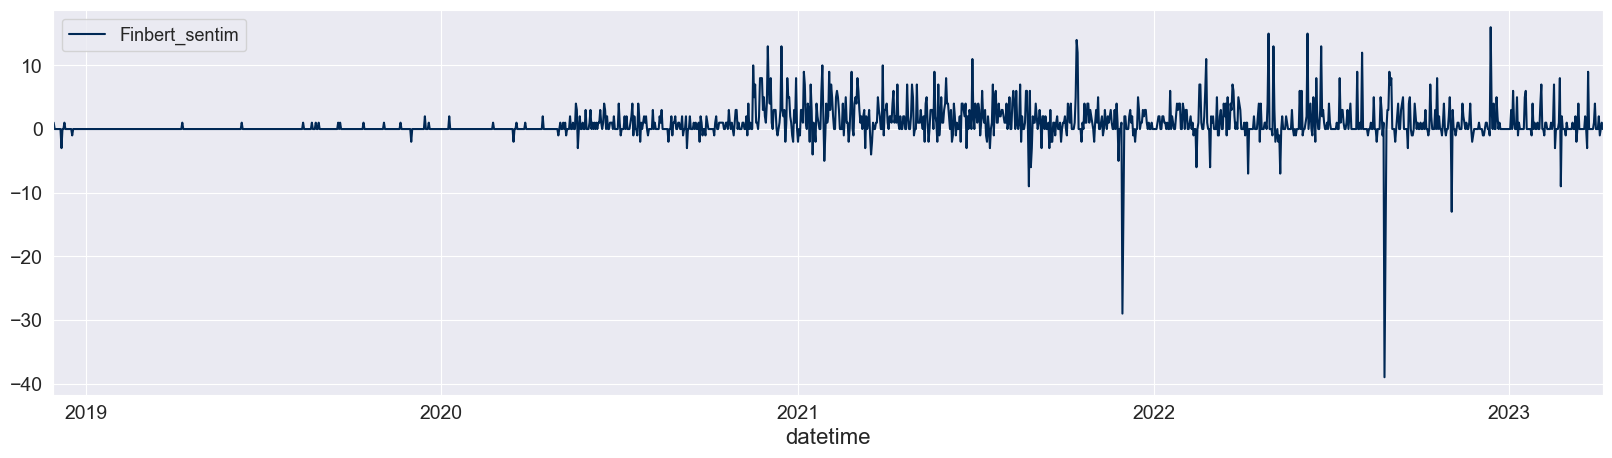

In [44]:
senti_quick_test[["Finbert_sentim"]].plot(figsize = (20,5))

In [74]:
merged_test[["Textblob_senti","textblob_senti_rolling", "Volume", "%Chg", "Close"]].corr()["textblob_senti_rolling"].abs().sort_values(ascending= False)

textblob_senti_rolling    1.000000
Textblob_senti            0.713212
Close                     0.205459
Volume                    0.125296
%Chg                      0.058676
Name: textblob_senti_rolling, dtype: float64

In [75]:
def plot_variables(check, column_name1, column_name2):

    # create a figure and an axis object
    fig, ax1 = plt.subplots(figsize=(12, 6))
    # plot the sentiment column on the primary y-axis
    ax1.plot(check.index, check[column_name1], color='blue')
    ax1.set_ylabel(column_name1)

    # create a secondary y-axis
    ax2 = ax1.twinx()

    # plot the Close column on the secondary y-axis
    ax2.plot(check.index, check[column_name2], color='red')
    ax2.set_ylabel(column_name2)

    # add a legend
    ax1.legend([column_name1], loc='upper left')
    ax2.legend([column_name2], loc='upper right')

    # show the plot
    plt.show()


---
# Twitter Data

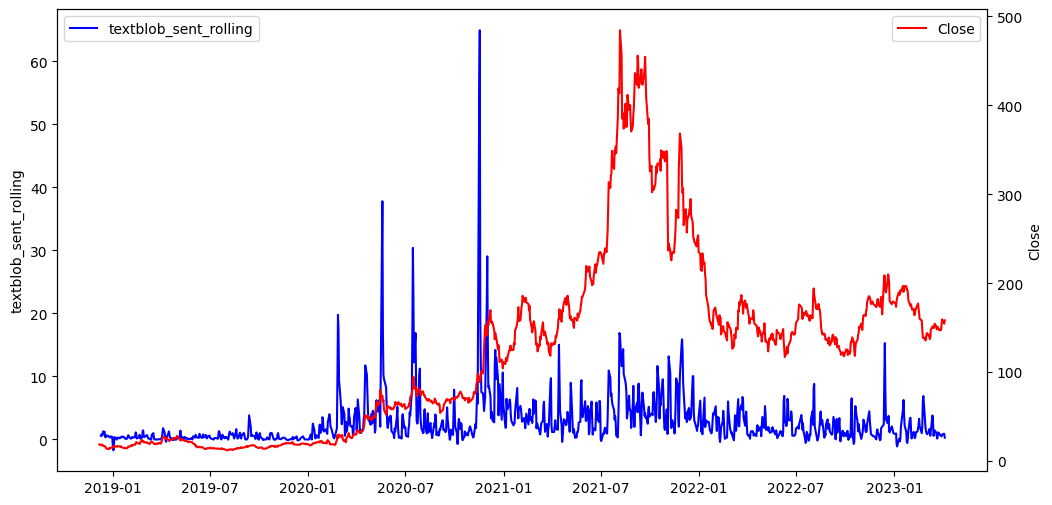

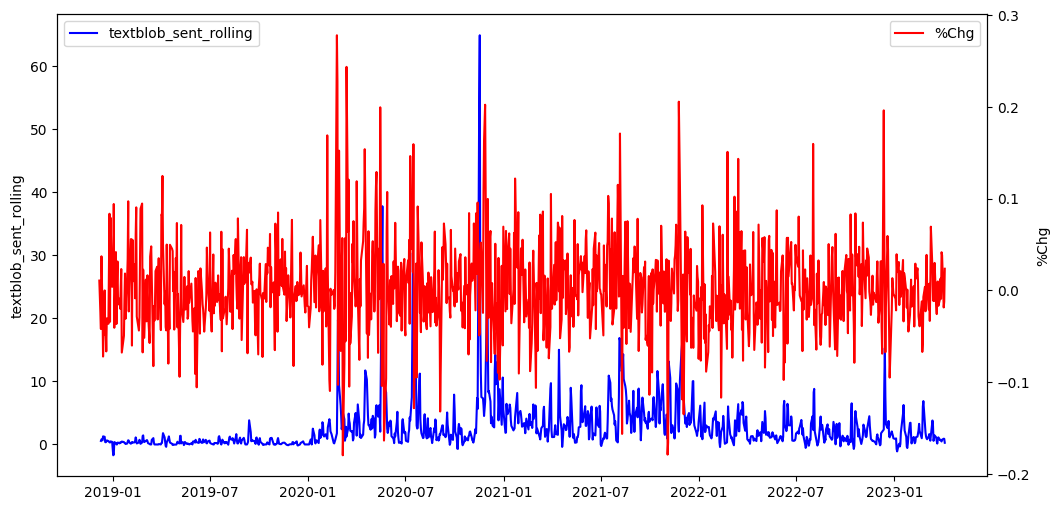

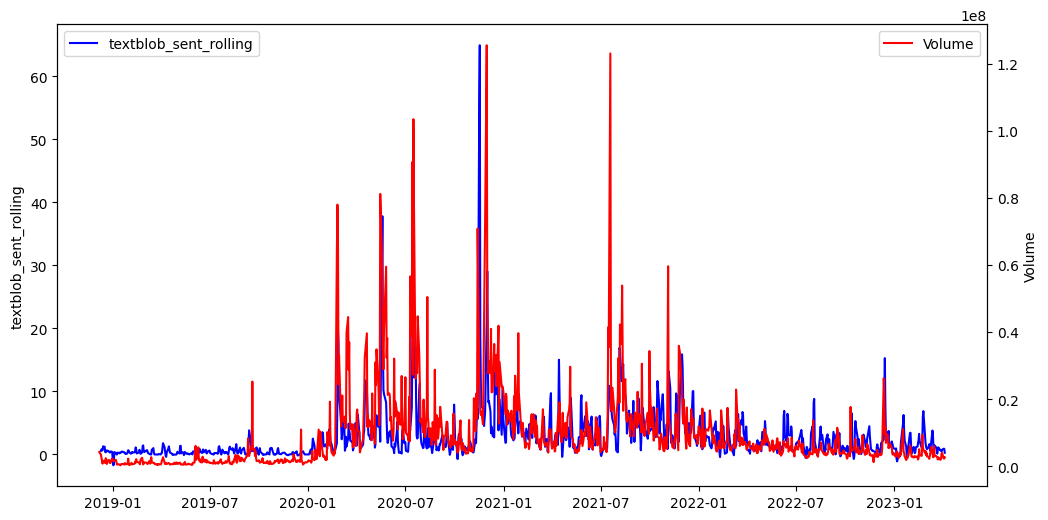

In [ ]:
plot_variables(check, "textblob_sent_rolling", "Close")
plot_variables(check, "textblob_sent_rolling", "%Chg")
plot_variables(check, "textblob_sent_rolling", "Volume")